## Homework  from Alexey Klimov

Download Microsoft stock price data for a period of '2017-07-01','2020-06-30' and calculate VaR curves using different approaches:

1. Use GARCH model with constant mean, EGARCH(2, 1, 2) and skewed t-student distribution of residuals
2. Use Generalized normal distribution (check this documenation https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gennorm.html)
3. Use a combination of GARCH and EVT: filter time series with GARCH and then model residuals with Excess Distribution Over a Threshold (hint: you need to take calculate_VaR_FHS() and "insert" a code from EVT section to the middle)


Then plot all VaR curves on one graph and conduct tests to select the most convenient approach. Finally, you should deliver:
1. One graph with daily historical returns and VaR curves
2. p-value for each model you use
3. Conclusion about what approach is the most suitable for this stock

In [104]:
import yfinance as yf

prices = yf.download('MSFT','2017-07-01','2020-06-30')

prices.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-06-30,68.779999,69.379997,68.739998,68.930000,64.966385,24161100
2017-07-03,69.330002,69.599998,68.019997,68.169998,64.250069,16165500
2017-07-05,68.260002,69.440002,68.220001,69.080002,65.107765,21176300
2017-07-06,68.269997,68.779999,68.120003,68.570000,64.627075,21117600
2017-07-07,68.699997,69.839996,68.699997,69.459999,65.465904,16878300


In [105]:
import numpy as np
import pandas as pd
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("bmh")
plt.rcParams['font.family'] = 'DejaVu Sans'

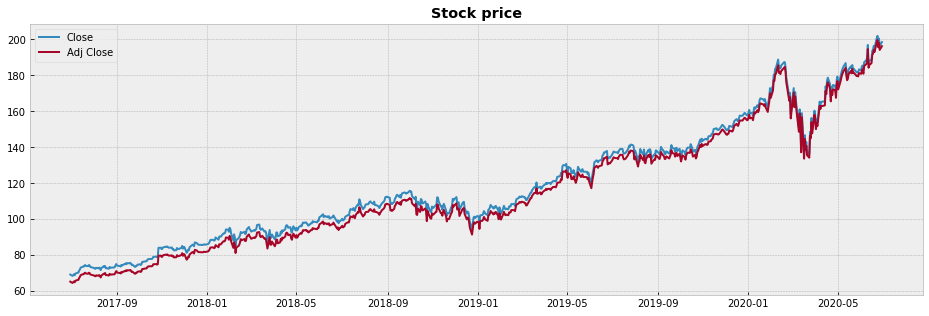

In [106]:
plot_fields =  ['Close', 'Adj Close']

fig = plt.figure(figsize=(16, 5))

plt.plot(prices[plot_fields])
plt.legend(plot_fields)

plt.title("Stock price", weight="bold")

plt.show()

In [107]:
print(prices.index)

prices.index = prices.index.to_period(freq='d')

print(prices.index)

DatetimeIndex(['2017-06-30', '2017-07-03', '2017-07-05', '2017-07-06',
               '2017-07-07', '2017-07-10', '2017-07-11', '2017-07-12',
               '2017-07-13', '2017-07-14',
               ...
               '2020-06-16', '2020-06-17', '2020-06-18', '2020-06-19',
               '2020-06-22', '2020-06-23', '2020-06-24', '2020-06-25',
               '2020-06-26', '2020-06-29'],
              dtype='datetime64[ns]', name='Date', length=754, freq=None)
PeriodIndex(['2017-06-30', '2017-07-03', '2017-07-05', '2017-07-06',
             '2017-07-07', '2017-07-10', '2017-07-11', '2017-07-12',
             '2017-07-13', '2017-07-14',
             ...
             '2020-06-16', '2020-06-17', '2020-06-18', '2020-06-19',
             '2020-06-22', '2020-06-23', '2020-06-24', '2020-06-25',
             '2020-06-26', '2020-06-29'],
            dtype='period[D]', name='Date', length=754)


In [108]:
price = prices['Adj Close']

price.head()

Date
2017-06-30    64.966385
2017-07-03    64.250069
2017-07-05    65.107765
2017-07-06    64.627075
2017-07-07    65.465904
Freq: D, Name: Adj Close, dtype: float64

In [109]:
dX = price.diff()

ret_log = np.log(price).diff()

ret = price.pct_change()



In [110]:
ret = ret.dropna()

### GARCH model with constant mean, EGARCH(2, 1, 2) and skewed t-student distribution of residuals

In [111]:
from arch import arch_model 

mdl = arch_model(100 * ret) # * 100 because it asked to do so

res = mdl.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 60184269259.32641
Iteration:      2,   Func. Count:     14,   Neg. LLF: 570199227.658143
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1513.4666723590715
Iteration:      4,   Func. Count:     27,   Neg. LLF: 1472.6148385368347
Iteration:      5,   Func. Count:     33,   Neg. LLF: 1365.9816691085937
Iteration:      6,   Func. Count:     39,   Neg. LLF: 1569.3494969166218
Iteration:      7,   Func. Count:     45,   Neg. LLF: 1355.5945764354105
Iteration:      8,   Func. Count:     50,   Neg. LLF: 1355.5500369944193
Iteration:      9,   Func. Count:     55,   Neg. LLF: 1355.5494028362841
Iteration:     10,   Func. Count:     60,   Neg. LLF: 1355.5480289933207
Iteration:     11,   Func. Count:     65,   Neg. LLF: 1355.5479849448188
Iteration:     12,   Func. Count:     70,   Neg. LLF: 1355.5479835355839
Iteration:     13,   Func. Count:     74,   Neg. LLF: 1355.5479835354424
Optimization terminated successfully    (Exit mode 0)


In [112]:
def calc_VaR(r, VaR_fun, L_history=252, level=0.05):
    VaR = np.full(r.size, np.nan)
    
    for i in range(L_history, len(r)):
        history = r[i - L_history: i]
        VaR[i] = VaR_fun(history, level)
        
    return pd.Series(data=VaR, index=r.index, name=VaR_fun.__name__)

In [113]:
def calculate_VaR_EGARCH(returns, alpha):
    
    scaling_const = 10.0 / returns.std()

    dist = 'skewstudent'
    am = arch_model(scaling_const * returns,
                    mean='Constant', lags=1, # mean = Constant, ARX, HARX + the number of lags
                    vol='EGARCH', p=2, o=1, q=2, # vol = Garch, EGARCH, HARCH + the number of lags
                    dist=dist) # dist = Normal, t, skewstudent, ged

    res = am.fit(update_freq=0, disp='off', tol=1e-01)

    forecasts = res.forecast(horizon=1)

    cond_mean = float(forecasts.mean.iloc[-1])
    cond_var = float(forecasts.variance.iloc[-1])

    if dist == 'Normal':
        q = am.distribution.ppf(alpha)
    elif dist == 't' or dist == 'ged':
        q = am.distribution.ppf(alpha, res.params[-1:])
    elif dist == 'skewstudent':
        q = am.distribution.ppf(alpha, res.params[-2:])

    return_garch_forecast = cond_mean / scaling_const
    VaR_EGARCH_forecast = (cond_mean + np.sqrt(cond_var) * q) / scaling_const

    return VaR_EGARCH_forecast

In [114]:
VaR_EGARCH = calc_VaR(ret, calculate_VaR_EGARCH, L_history=252, level=alpha)

In [115]:
VaR_EGARCH

Date
2017-07-03         NaN
2017-07-05         NaN
2017-07-06         NaN
2017-07-07         NaN
2017-07-10         NaN
                ...   
2020-06-23   -0.030354
2020-06-24   -0.029271
2020-06-25   -0.031918
2020-06-26   -0.029943
2020-06-29   -0.034200
Freq: D, Name: calculate_VaR_EGARCH, Length: 753, dtype: float64

### Use Generalized normal distribution (check this documenation https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gennorm.html)

In [159]:
import scipy.stats as ss
from scipy.stats import gennorm

params_gennorm = ss.gennorm.fit(ret)
a , b , c = params_gennorm

VaR_gennorm = ss.gennorm.ppf(alpha, a , b , c)


print('Value-at-Risk: {:.2f}%'.format(100*VaR_gennorm))

Value-at-Risk: -2.76%


In [163]:
def calculate_VaR_gennorm(ret, alpha=0.05):

    params_gennorm = ss.gennorm.fit(ret)
    a , b , c = params_gennorm

           
    return ss.gennorm.ppf(alpha, a , b , c)

In [164]:
VaR_gennorm = calc_VaR(ret, calculate_VaR_gennorm, L_history=252, level=alpha)

### Use a combination of GARCH and EVT: filter time series with GARCH and then model residuals with Excess Distribution Over a Threshold (hint: you need to take calculate_VaR_FHS() and "insert" a code from EVT section to the middle)

In [188]:
def calculate_mdl_maximas(ret, alpha=0.05):
    
    maximas = ret.resample('W').min()
    
    params_genextreme = ss.genextreme.fit(maximas)
    

    return params_genextreme

In [189]:
calculate_mdl_maximas(ret, alpha=0.05)

(0.6064924602213426, -0.019807817960403866, 0.01868303745697997)

In [192]:
def calculate_VaR_FHS(returns, alpha):
    
    scaling_const = 10.0 / returns.std()

    mdl = arch_model(scaling_const * returns,
                    mean='HARX', lags=1, # mean = Constant, ARX, HARX + the number of lags
                    vol='Garch', p=1, o=1, q=1, # vol = Garch, EGARCH, HARCH + the number of lags
                    dist='normal')

    res = mdl.fit(disp='off')

   # get Standartized residuals
    u = ret.quantile(0.2)
    ret_tail = ret[ret <= u]

    c, loc, scale = ss.genpareto.fit(-ret_tail, loc=0)
    
    return u - scale / c * ((alpha/(ret <= u).mean())**(-c) - 1)
    
    #не понял как считать остатки по EVT
    stand_residuals = res.resid / res.conditional_volatility
    stand_residuals = stand_residuals.dropna()


    # forecast mean and variance one step ahead
    forecasts = res.forecast(horizon=1)
    cond_mean = float(forecasts.mean.iloc[-1])
    cond_var = float(forecasts.variance.iloc[-1])

    # conditional stand_residuals
    conditional_sr = cond_mean + np.sqrt(cond_var) * stand_residuals
    conditional_sr = conditional_sr / scaling_const

    # calculate VaR as quantile
    VaR_FHS = conditional_sr.quantile(alpha)

    return VaR_FHS

In [193]:
VaR_FHS = calc_VaR(ret, calculate_VaR_FHS, L_history=252, level=alpha)

In [178]:
VaR_FHS

Date
2017-07-03         NaN
2017-07-05         NaN
2017-07-06         NaN
2017-07-07         NaN
2017-07-10         NaN
                ...   
2020-06-23   -0.035181
2020-06-24   -0.027480
2020-06-25   -0.028751
2020-06-26   -0.029764
2020-06-29   -0.028657
Freq: D, Name: calculate_VaR_FHS, Length: 753, dtype: float64

In [202]:
def calc_hits(returns, VaRs):
    return ((VaRs - returns).dropna() > 0).values

def zone(p):
    if p > 0.05:
        return 'green'
    elif p > 0.0001:
        return 'yellow'
    else:
        return 'red'

def backtest_VaR(r, VaR, level, L=None):
    # to skip starting NaNs
    if L is None:
        L = (~VaR.isna()).to_numpy().nonzero()[0][0];
    r = r[L:]
    VaR = VaR[L:]
    
    hits = calc_hits(r, VaR)    
    
    p_value_two_sided = ss.binom_test(sum(hits), len(hits), 1-level, alternative = 'two-sided')
    p_value_conservative = ss.binom_test(sum(hits), len(hits), 1-level, alternative = 'greater')
    print(f'Backtesting {VaR.name}:')
    print(f'The proportion of hits is {(sum(hits)/len(hits))*100:.3}% instead of expected {(1-level)*100:.3}%')
    print(f'Two-sided p-val {p_value_two_sided:.3}, one-sided: {p_value_conservative:.3}')
    print(f'{zone(p_value_two_sided)} zone\n')

### One graph with daily historical returns and VaR curves

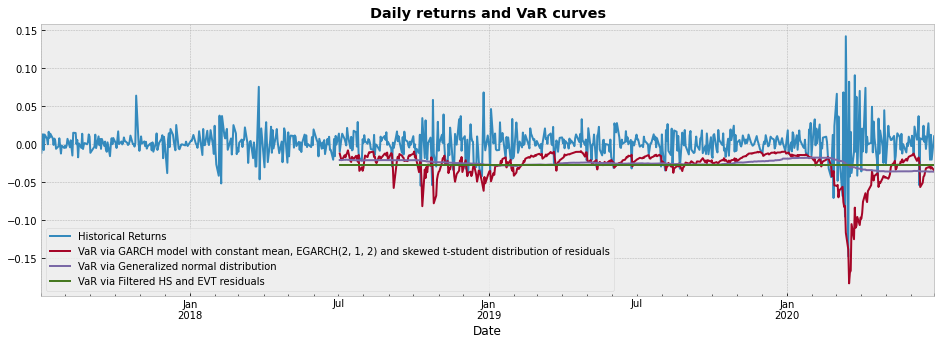

In [203]:
fig = plt.figure(figsize=(16, 5))

ret.plot()
VaR_EGARCH.plot()
VaR_gennorm.plot()
VaR_FHS.plot()

plt.title("Daily returns and VaR curves", weight="bold")

plt.legend(['Historical Returns',
            'VaR via GARCH model with constant mean, EGARCH(2, 1, 2) and skewed t-student distribution of residuals',
            'VaR via Generalized normal distribution', 
           'VaR via Filtered HS and EVT residuals'])

plt.show()

### p-value for each model you use

In [204]:
backtest_VaR(ret, VaR_EGARCH, 1-alpha)
backtest_VaR(ret, VaR_gennorm, 1-alpha)
backtest_VaR(ret, VaR_FHS, 1-alpha)

Backtesting calculate_VaR_EGARCH:
The proportion of hits is 6.79% instead of expected 5.0%
Two-sided p-val 0.08, one-sided: 0.0465
green zone

Backtesting calculate_VaR_gennorm:
The proportion of hits is 7.78% instead of expected 5.0%
Two-sided p-val 0.0073, one-sided: 0.00476
yellow zone

Backtesting calculate_VaR_FHS:
The proportion of hits is 6.99% instead of expected 5.0%
Two-sided p-val 0.0504, one-sided: 0.031
green zone



### Conclusion about what approach is the most suitable for this stock

Для данной акции MSFT с учетом волатильности лучше всего работает модель EGARCH. Даже с учетом значений p-value и теста Купика получается, что модель EGARCH предпочтительнее остальных. 